作业五 相似度计算  
任务描述：采用word2vec方法，进行句子相似度计算训练。  
  
给出一个有关句子相似度的二分类数据集msr_paraphrase（包含train、test、README三个文件），其中第一列数字1代表相似，0代表不相似。  
选择文件train中的string1&2部分作为训练语料，选择文件test计算句子相似度，然后与标注结果比较，输出你认为合适的分类阈值，以及该阈值下的准确率Accuracy，精确率Precision，召回率Recall和F1值（精确到小数点后两位）。  
  
句向量相似度计算方式：  
首先对句子分词，获取每个词的词向量，然后将所有的词向量相加求平均，得到句子向量，最后计算两个句子向量的余弦值(余弦相似度)。  

Word2vec部分，使用Gensim的Word2Vec训练模型，自行调整合适的参数。  
注意可能会出现word xx not in vocabulary的情况，这是由于训练时默认参数min_count=5，会过滤掉低频词。可以手动设定min_count=1，或者在计算句向量时，遇到低频词则忽略。自行选择其一，并注释。  
gensim镜像安装方式  
pip install -i https://pypi.tuna.tsinghua.edu.cn/simple gensim  
导入方式from gensim.models import word2vec  


**1.读取文本并对句子分词**

In [1]:
import pandas as pd
import nltk.tokenize as tk
import re

data = pd.read_csv('msr_train.csv',keep_default_na=False)    # 读取train文件，设置忽略NAN，否则后期会出问题

num_row, num_col = (data.shape)        # 记录train中的行列值 

sentences= []                          # 记录train中读到的句子

pattern = re.compile("[^a-zA-Z0-9\n ]")# 定义去标点用的模式

def formating(words):                  # 定义一个格式化函数（对传入列表匹配英文单词并全部转小写）
    new_words = []
    for i in words:
        pattern = re.compile("[^a-zA-Z\n ]")
        word = re.sub(pattern, "", i).lower()
        if(word!=''):                  
            new_words.append(re.sub(pattern, "", i).lower())
    return new_words

for i in range(num_row):               # 分词
    words_1 = tk.word_tokenize(data['#1 String'].loc[i])
    words_2 = tk.word_tokenize(data['#2 String'].loc[i])
    sentences.append(formating(words_1))
    sentences.append(formating(words_2))
print(sentences[:5])                   # 随便输出几个

[['amrozi', 'accused', 'his', 'brother', 'whom', 'he', 'called', 'the', 'witness', 'of', 'deliberately', 'distorting', 'his', 'evidence'], ['referring', 'to', 'him', 'as', 'only', 'the', 'witness', 'amrozi', 'accused', 'his', 'brother', 'of', 'deliberately', 'distorting', 'his', 'evidence'], ['yucaipa', 'owned', 'dominick', 's', 'before', 'selling', 'the', 'chain', 'to', 'safeway', 'in', 'for', 'billion'], ['yucaipa', 'bought', 'dominick', 's', 'in', 'for', 'million', 'and', 'sold', 'it', 'to', 'safeway', 'for', 'billion', 'in'], ['they', 'had', 'published', 'an', 'advertisement', 'on', 'the', 'internet', 'on', 'june', 'offering', 'the', 'cargo', 'for', 'sale', 'he', 'added']]


**2.用Word2vec训练出每个词的词向量**

In [2]:
from gensim.models import word2vec

model = word2vec.Word2Vec(sentences, size=200, min_count=1)  # 训练skip-gram模型; 默认window=5

print(model['who'][:5])  # 输出某个词词向量的一部分，以确认模型生成好了. 由于方法快过时了，所以会有红色的警告

[-0.28016183  1.3721012  -0.24419113  1.3583531   0.70664674]


C:\Users\Hairaa\anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


**3.将所有的词向量相加求平均，得到句子向量，最后计算两个句子向量的余弦值(余弦相似度)。**

In [3]:
import numpy as np

def sentence_vector(s):      #计算句子向量
    vec = np.zeros(200)
    for word in s:
        vec += model[word]
    vec /= len(s)
    return vec

def sentence_similarity(s1, s2):    #计算两个句子向量的余弦值（用numpy可以写的很优雅）
    v1, v2 = sentence_vector(s1), sentence_vector(s2)
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

for i in range(0, 6, 2):           #测试几个句子的相似值
    print(sentence_similarity(sentences[i],sentences[i + 1]))

0.9992973667352674
0.99995695964513
0.9993696847794646


C:\Users\Hairaa\anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


**4.输出你认为合适的分类阈值**

In [4]:
import csv

#  寻找最好的分类阈值理论上可以用多种方法来做，比如决策树等人工智能方法

#  由于时间有限我选择通过平均值选取

#  把相似度和标签写入到csv里面
csv_file = open("msr_classify.csv","w",newline = "")
classify_data = csv.writer(csv_file)
for i in range (num_row):
    sentence_1 = formating(tk.word_tokenize(data['#1 String'].loc[i]))
    sentence_2 = formating(tk.word_tokenize(data['#2 String'].loc[i]))
    classify_data.writerow([data['Quality'].loc[i], sentence_similarity(sentence_1,sentence_2)])
csv_file.close()

C:\Users\Hairaa\anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
C:\Users\Hairaa\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


由msr_classify.csv得到：
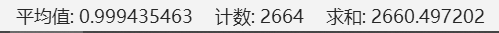
**正数据的平均相似度**

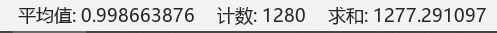
**负数据的平均相似度**

**将阈值取值为：0.998663876**

**5.该阈值下的准确率Accuracy，精确率Precision，召回率Recall和F1值（精确到小数点后两位）**

$$Accuracy = \frac{TP+TN}{TP+TN+FP+FN}$$


$$Precision = \frac{TP}{TP+FP}$$


$$Recall = \frac{TP}{TP+FN}$$


$$F_1 = \frac{2TP}{2TP+FP+FN}$$

In [7]:
Accuracy_image = []
Precision_image = []
Recall_image = []
F1_image = []
#  定义TP、FP、TN、FN
def find_num(number):
    csv_file = csv.reader(open("msr_classify.csv", 'r'))
    true_pos, false_pos, true_neg, false_neg = 0, 0, 0, 0
    for i in csv_file:
        if float(i[1]) > number:
            tag = '1'
        else:
            tag = '0'
        if(tag == i[0]):     #  True类
            if(i[0]=='0'):
                true_neg+=1  #  TN
            else:
                true_pos+=1  #  TP
        else:
            if(i[0]=='0'):
                false_pos+=1 #  FP
            else:
                false_neg+=1 #  FN

    #print(true_pos, false_pos, true_neg, false_neg)

    Accuracy = (true_pos + true_neg)/(true_pos + false_pos + true_neg + false_neg)
    Precision = true_pos / (true_pos + false_pos)
    Recall = true_pos / (true_pos + false_neg)
    F1 = 2*true_pos / (2*true_pos + false_pos + false_neg)
    
    Accuracy_image.append(Accuracy)
    Precision_image.append(Precision)
    Recall_image.append(Recall)
    F1_image.append(F1)
    #print("%.2f"%Accuracy)
    #print("%.2f"%Precision)
    #print("%.2f"%Recall)
    #print("%.2f"%F1)

#  阈值选的不太成功(lll￢ω￢)

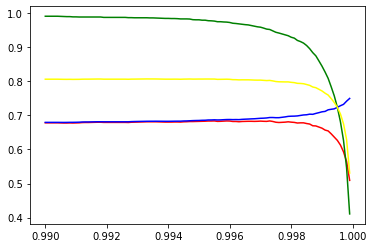

In [8]:
import matplotlib.pyplot as plt

indexs = []

for i in range(100):
    find_num(0.99+0.0001*i)
    indexs.append(0.99+0.0001*i)

plt.plot(indexs,Accuracy_image,color='red')
plt.plot(indexs,Precision_image,color='blue')
plt.plot(indexs,Recall_image,color='green')
plt.plot(indexs,F1_image,color='yellow')
plt.show()